In [3]:
import scanpy as sc
import re
import numpy as np

In [4]:
def get_clono_features(features):
    patterns = [
        "TRAV", "TRAJ", "TRBV", "TRBJ", "TRDV", "TRDJ", "TRGV", "TRGJ",
        "IGKV", "IGKJ", "IGLV", "IGLJ", "IGHV", "IGHJ"
    ]
    additional_features = ["XIST", "RPS4Y1", "RPS4Y2", "MT"]

    clono_features = []
    
    for pattern in patterns:
        clono_features.extend([i for i, feature in enumerate(features) if re.search(pattern, feature)])
    
    clono_features.extend([i for i, feature in enumerate(features) if feature in additional_features])
    
    clono_features = np.unique(clono_features).tolist()
    
    return clono_features

In [5]:
adata = sc.read_h5ad("data/raw_counts_adata.h5ad")

/home/bench-user/.apps/conda/envs/scanorama_env/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/bench-user/.apps/conda/envs/scanorama_env/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [6]:
adata.var

,gene_name
0,AP006222.2
1,FAM87B
2,LINC00115
3,FAM41C
4,SAMD11
...,...
15364,MT-ND4L
15365,MT-ND4
15366,MT-ND5
15367,MT-ND6


In [7]:
# remove clonotype, sex and mitochondrial genes
rm_gene_indices = get_clono_features(adata.var.gene_name.tolist())
mask = np.ones(adata.X.shape[1], dtype=bool) # create a boolean mask for the genes to keep
mask[rm_gene_indices] = False

Tcell_data = adata[:, mask]

In [7]:
Tcell_data


View of AnnData object with n_obs × n_vars = 25066 × 15219
    obs: 'cell_id', 'nCount_RNA', 'nFeature_RNA', 'patient_id', 'percent_mito', 'Response_3m', 'sample_source'
    var: 'gene_name'

In [8]:
Tcell_data.X.max()


np.float32(3051.0)

In [9]:
# save count data
Tcell_data.layers['counts'] = Tcell_data.X.copy()

/tmp/ipykernel_107965/2723759075.py:2: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  Tcell_data.layers['counts'] = Tcell_data.X.copy()


In [10]:
sc.pp.normalize_total(Tcell_data, target_sum=1e4)
sc.pp.log1p(Tcell_data)

In [11]:
sc.pp.highly_variable_genes(Tcell_data)

In [12]:
var_genes_all = Tcell_data.var.highly_variable

print("higly var genes: %d"%sum(var_genes_all))

higly var genes: 2940


In [13]:
Tcell_data2 = Tcell_data.copy() # make a copy of the data to work with

In [14]:
# detect variable genes for each batch
sc.pp.highly_variable_genes(Tcell_data2, batch_key='sample_source')

In [15]:
print("highly variable intersection: %d"%sum(Tcell_data2.var.highly_variable_intersection))

highly variable intersection: 424


In [16]:
print("Number of batches where gene is variable:")
print(Tcell_data2.var.highly_variable_nbatches.value_counts())

var_genes_batch = Tcell_data2.var.highly_variable_nbatches > 0

Number of batches where gene is variable:
highly_variable_nbatches
0    8681
1    3205
2    1888
3    1021
4     424
Name: count, dtype: int64


In [17]:
print("Any batch var genes: %d"%sum(var_genes_batch))
print("All data var genes: %d"%sum(var_genes_all))
print("Overlap: %d"%sum(var_genes_batch & var_genes_all))
print("Variable genes in all batches: %d"%sum(Tcell_data2.var.highly_variable_nbatches == 4))
print("Overlap batch instersection and all: %d"%sum(var_genes_all & Tcell_data2.var.highly_variable_intersection))

Any batch var genes: 6538
All data var genes: 2940
Overlap: 2912
Variable genes in all batches: 424
Overlap batch instersection and all: 405


In [18]:
var_select = Tcell_data2.var.highly_variable_nbatches > 1 # select genes that are variable in at least 2 batches, chose this because max_seq_len of classifier is 3001
var_genes = var_select.index[var_select]
len(var_genes)

3333

Integrating datasets with scanorama

In [19]:
batches = Tcell_data2.obs.sample_source.cat.categories.tolist()
alldata = {}
for batch in batches:
    alldata[batch] = Tcell_data2[Tcell_data2.obs.sample_source == batch, :]

alldata

{'Good': View of AnnData object with n_obs × n_vars = 6203 × 15219
     obs: 'cell_id', 'nCount_RNA', 'nFeature_RNA', 'patient_id', 'percent_mito', 'Response_3m', 'sample_source'
     var: 'gene_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
     uns: 'log1p', 'hvg'
     layers: 'counts',
 'Deng': View of AnnData object with n_obs × n_vars = 11353 × 15219
     obs: 'cell_id', 'nCount_RNA', 'nFeature_RNA', 'patient_id', 'percent_mito', 'Response_3m', 'sample_source'
     var: 'gene_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
     uns: 'log1p', 'hvg'
     layers: 'counts',
 'Harad': View of AnnData object with n_obs × n_vars = 6570 × 15219
     obs: 'cell_id', 'nCount_RNA', 'nFeature_RNA', 'patient_id', 'percent_mito', 'Response_3m', 'sample_source'
     var: 'gene_name', 'highly_variable', 'means', 'dispersions', 'dispersi

In [20]:
import scanorama

alldata2 = dict()
for ds in alldata.keys():
    print(ds)
    alldata2[ds] = alldata[ds][:,var_genes] # select only variable genes

# convert to list of Anndata objects
adatas = list(alldata2.values())

corrected = scanorama.correct_scanpy(adatas, return_dimred=True)


Good
Deng
Harad
Sheih
Found 3333 genes among all datasets
[[0.         0.50620667 0.45719813 0.24148936]
 [0.         0.         0.59640624 0.39042553]
 [0.         0.         0.         0.68085106]
 [0.         0.         0.         0.        ]]
Processing datasets (2, 3)
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)
Processing datasets (1, 3)
Processing datasets (0, 3)


In [21]:
corrected[1].X.min(), corrected[1].X.max() 

(np.float64(-0.05369821104303046), np.float64(0.24313763157771764))

In [32]:
corrected[1].X.min(), corrected[1].X.max()  

(-0.021710490584638416, 0.35355487724025275)

In [28]:
corrected[3].var.equals(corrected[1].var)

True

In [25]:
is_equal = corrected[0].var.equals(corrected[1].var)
print(is_equal)

,gene_name,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection
10,ISG15,False,0.852935,1.220471,0.321338,2,False
1000,ZBTB7B,False,0.159602,1.252896,0.466728,2,False
10007,PTGDR,True,0.050510,1.646717,1.142154,3,False
10008,PTGER2,True,0.745021,1.373919,0.674403,3,False
10009,TXNDC16,True,0.081497,1.506513,0.935013,3,False
...,...,...,...,...,...,...,...
9993,L2HGDH,False,0.080119,1.056423,0.150857,2,False
9995,MAP4K5,True,0.249404,1.343252,0.742932,3,False
9996,ATL1,False,0.017038,1.150185,0.223755,2,False
9997,SAV1,False,0.041876,1.009684,0.244003,2,False


In [29]:
#import anndata as ad
sc_adata = ad.concat(corrected, axis=0, merge='same') # merge='same' to keep the var layer

In [23]:
sc_adata

AnnData object with n_obs × n_vars = 25066 × 3333
    obs: 'cell_id', 'nCount_RNA', 'nFeature_RNA', 'patient_id', 'percent_mito', 'Response_3m', 'sample_source'
    obsm: 'X_scanorama'

In [30]:
sc_adata.var

,gene_name,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection
10,ISG15,False,0.852935,1.220471,0.321338,2,False
1000,ZBTB7B,False,0.159602,1.252896,0.466728,2,False
10007,PTGDR,True,0.050510,1.646717,1.142154,3,False
10008,PTGER2,True,0.745021,1.373919,0.674403,3,False
10009,TXNDC16,True,0.081497,1.506513,0.935013,3,False
...,...,...,...,...,...,...,...
9993,L2HGDH,False,0.080119,1.056423,0.150857,2,False
9995,MAP4K5,True,0.249404,1.343252,0.742932,3,False
9996,ATL1,False,0.017038,1.150185,0.223755,2,False
9997,SAV1,False,0.041876,1.009684,0.244003,2,False


In [31]:
sc_adata.X.min(), sc_adata.X.max()

(np.float64(-0.07472164559707727), np.float64(0.2883085147287645))

In [32]:
sc.pp.neighbors(sc_adata, n_pcs = 30, use_rep='X_scanorama')
sc.tl.umap(sc_adata)
sc.tl.tsne(sc_adata, n_pcs = 30, use_rep='X_scanorama')

/home/bench-user/.apps/conda/envs/scanorama_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [33]:
sc_adata

AnnData object with n_obs × n_vars = 25066 × 3333
    obs: 'cell_id', 'nCount_RNA', 'nFeature_RNA', 'patient_id', 'percent_mito', 'Response_3m', 'sample_source'
    var: 'gene_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'neighbors', 'umap', 'tsne'
    obsm: 'X_scanorama', 'X_umap', 'X_tsne'
    obsp: 'distances', 'connectivities'

<Axes: title={'center': 'Scanorama umap'}, xlabel='UMAP1', ylabel='UMAP2'>

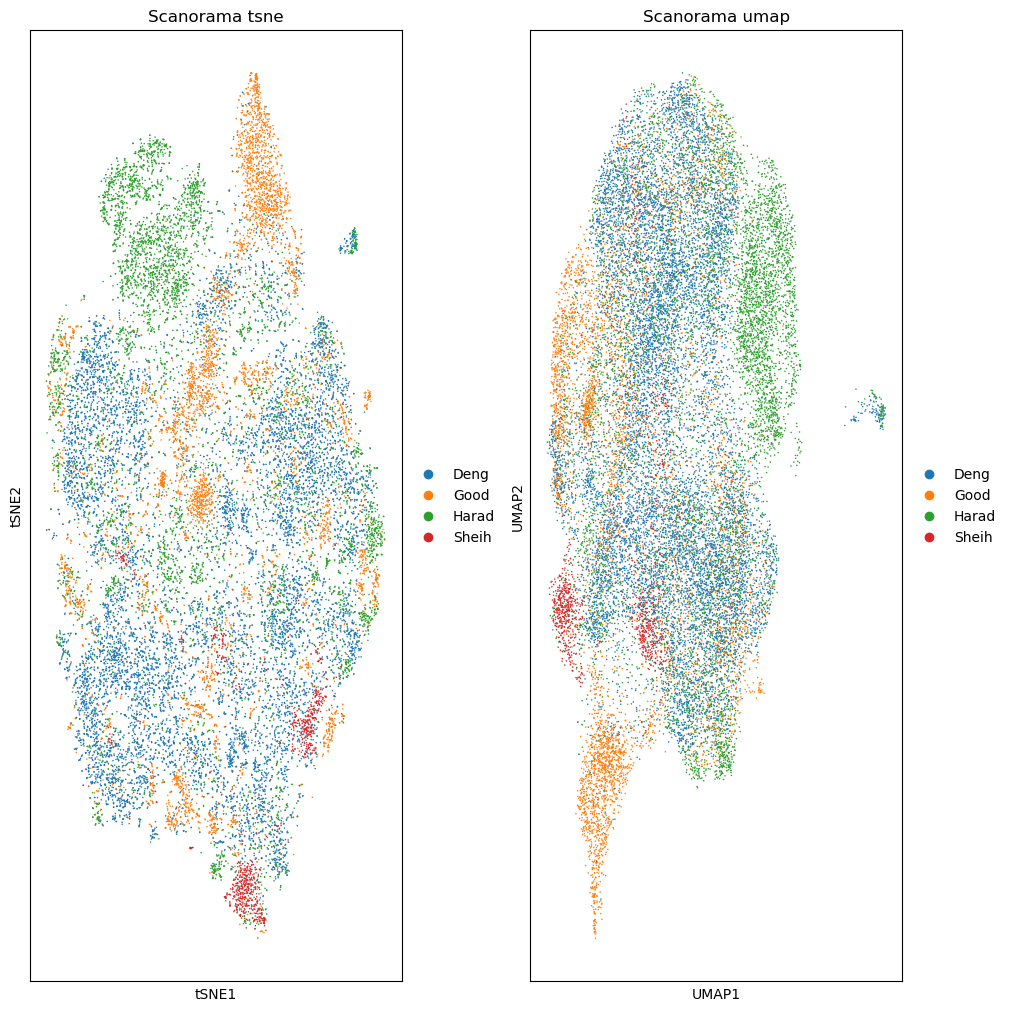

In [34]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(10,10),constrained_layout=True)
sc.pl.tsne(sc_adata, color="sample_source", title="Scanorama tsne", ax=axs[0], show=False)
#sc.pl.tsne(adata_sc, color="sample", title="Scanorama tsne", ax=axs[0,1], show=False)
sc.pl.umap(sc_adata, color="sample_source", title="Scanorama umap", ax=axs[1], show=False)
#sc.pl.umap(adata_sc, color="sample", title="Scanorama umap", ax=axs[1,1], show=False)

In [35]:
sc_adata.write_h5ad("data/scanorama_corrected.h5ad")